# Calculate Bulk Modulus with Quantum Espresso

In [1]:
import os
import subprocess
from ase.build import bulk
from atomistics.workflows.evcurve.helper import (
    analyse_structures_helper as evcurve_analyse_structures,
    generate_structures_helper as evcurve_generate_structures,
)
from executorlib import FluxClusterExecutor
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm
from time import sleep

In [2]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [3]:
structure_dict = evcurve_generate_structures(
    structure=bulk("Al", a=4.15, cubic=True),
    num_points=7,
    vol_range=0.05,
    axes=("x", "y", "z"),
)

In [4]:
task_loop_dict = {k: {"calc_energy": v} for k, v in structure_dict.items()}

In [5]:
def evaluate_with_quantum_espresso(task_dict, pseudopotentials, kpts):
    from ase.calculators.espresso import Espresso, EspressoProfile
    from atomistics.calculators import evaluate_with_ase
    
    return evaluate_with_ase(
        task_dict=task_dict,
        ase_calculator=Espresso(
            pseudopotentials=pseudopotentials,
            tstress=True,
            tprnfor=True,
            kpts=kpts,
            profile=EspressoProfile(
                 command="flux run pw.x",
                 pseudo_dir="/home/runner/work/executorlib/executorlib/tests/integration",
            ),
        ),
    )["energy"]

In [6]:
pprint.pp(subprocess.check_output(["flux", "resource", "list"], universal_newlines=True).split("\n"))

['     STATE NNODES   NCORES    NGPUS NODELIST',
 '      free      1        2        1 '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 ' allocated      0        0        0 ',
 '      down      0        0        0 ',
 '']


In [7]:
pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))

['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO', '']


In [8]:
future_dict = {}
with FluxClusterExecutor() as exe:
    for k, v in task_loop_dict.items():
        future_dict[k] = exe.submit(
            evaluate_with_quantum_espresso, 
            task_dict=v, 
            pseudopotentials=pseudopotentials, 
            kpts=(3, 3, 3), 
            resource_dict={"cores": 1, "threads_per_core": 2},
        )
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))
    result_dict = {
        k: f.result() 
        for k, f in tqdm(future_dict.items())
    }
    sleep(1)
    pprint.pp(subprocess.check_output(["flux", "jobs", "-a"], universal_newlines=True).split("\n"))

['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒGjJX3zF jan      executorl+  S      2      -        - ',
 '    ƒGqk7w19 jan      executorl+  S      2      -        - ',
 '    ƒGwj32wq jan      executorl+  S      2      -        - ',
 '    ƒGdhqmGj jan      executorl+  R      2      1   0.863s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:31<00:00, 47.33s/it]


['       JOBID USER     NAME       ST NTASKS NNODES     TIME INFO',
 '    ƒHJcGvBZ jan      executorl+ CD      2      1   11.67s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒHCVwsq9 jan      executorl+ CD      2      1   36.25s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒH6BkwDy jan      executorl+ CD      2      1    43.6s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒGwj32wq jan      executorl+ CD      2      1   36.27s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒGqk7w19 jan      executorl+ CD      2      1   1.804m '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒGjJX3zF jan      executorl+ CD      2      1   44.15s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '    ƒGdhqmGj jan      executorl+ CD      2      1   52.96s '
 'p200300e77f488c5f903797efb75a6bf7.dip0.t-ipconnect.de',
 '']


In [9]:
fit_dict = evcurve_analyse_structures(
    output_dict={"energy": result_dict},
    structure_dict=structure_dict,
    fit_type="polynomial",
    fit_order=3,
)

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_44137/4024930470.py:2: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Volume [$\AA^3$]")


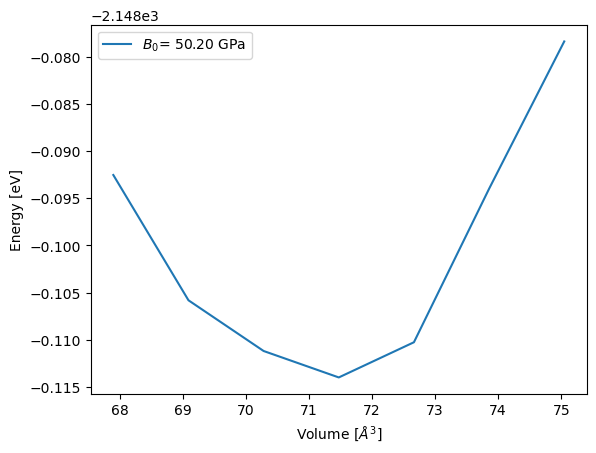

In [10]:
plt.plot(fit_dict["volume"], fit_dict["energy"], label="$B_0$= %0.2f GPa" % fit_dict["bulkmodul_eq"])
plt.xlabel("Volume [$\AA^3$]")
plt.ylabel("Energy [eV]")
plt.legend()